This notebook is part of an article about how to forecast and detect anomalies on time-series data. This is a complementary approach where I show how to implement multistep forecasting - The main objective is to train a RNN regressor on the Bitcoin dataset to predict future values on then detect anomalies in the whole data window - that last step achieved by implementing a K-Means Clustering model.

The dataset used was acquired by myself from the NOAA website.

# Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import datetime
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers 
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import load_model
import json
import urllib
from datetime import datetime, timedelta,timezone
import requests
from pprint import pprint

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nyweatherdata/2397610.csv
/kaggle/input/nyweatherdatahourly/2397620.csv
/kaggle/input/miamiweatherdata/2397728.csv


In [2]:
weather = pd.read_csv('/kaggle/input/nyweatherdata/2397610.csv')
weather.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,AWND_ATTRIBUTES,PGTM,PGTM_ATTRIBUTES,...,TMIN,TMIN_ATTRIBUTES,WDF2,WDF2_ATTRIBUTES,WDF5,WDF5_ATTRIBUTES,WSF2,WSF2_ATTRIBUTES,WSF5,WSF5_ATTRIBUTES
0,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,-73.76401,3.4,2015-12-26,4.8,",,W",NaN,NaN,...,9.4,",,W",10.0,",,W",10.0,",,W",9.4,",,W",11.6,",,W"
1,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,-73.76401,3.4,2015-12-27,5.5,",,W",NaN,NaN,...,8.9,",,W",320.0,",,W",320.0,",,W",10.3,",,W",13.0,",,W"
2,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,-73.76401,3.4,2015-12-28,6.3,",,W",NaN,NaN,...,1.7,",,W",320.0,",,W",80.0,",,W",10.3,",,W",16.5,",,W"
3,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,-73.76401,3.4,2015-12-29,5.3,",,W",NaN,NaN,...,1.1,",,W",80.0,",,W",90.0,",,W",10.7,",,W",13.4,",,W"
4,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",40.63915,-73.76401,3.4,2015-12-30,3.0,",,W",NaN,NaN,...,5.0,",,W",350.0,",,W",340.0,",,W",9.8,",,W",11.6,",,W"


# Data preprocessing

In [3]:
weather = weather[['DATE','AWND','PRCP','TAVG']]
weather.fillna(method ='ffill', inplace = True)
print('NaN values: ',weather.isna().sum())

NaN values:  DATE    0
AWND    0
PRCP    0
TAVG    0
dtype: int64


In [4]:
weather['DATE'] = pd.to_datetime(weather['DATE'])
weather.set_index('DATE',drop=True,inplace=True)

In [5]:
weather['AWND'] = weather['AWND']*3.6
weather.head()

,AWND,PRCP,TAVG
DATE,,,
2015-12-26,17.28,0.3,13.1
2015-12-27,19.80,2.0,12.1
2015-12-28,22.68,1.3,7.5
2015-12-29,19.08,16.8,5.5
2015-12-30,10.80,9.4,6.2


In [6]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=weather.index, y=weather['TAVG'],name='TAVG'))
fig.update_layout(showlegend=True)
fig.show()

In [7]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=weather.index, y=weather['AWND'],name='AWND'))
fig.update_layout(showlegend=True)
fig.show()

In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=weather.index, y=weather['PRCP'],name='PRCP'))
fig.update_layout(showlegend=True)
fig.show()

# Data splitting

In [9]:
data_for_us = weather.copy() #To be used later on Unsupervised Learning
training_start = int(len(weather) * 0.2)

feature = weather.copy()[['PRCP']]

train = feature.iloc[training_start:]
test = feature.iloc[:training_start]
print("Total datasets' lenght: ",train.shape, test.shape)

Total datasets' lenght:  (1463, 1) (365, 1)


# Data scaling

In [10]:
scaler = MinMaxScaler().fit(train[['PRCP']])

In [11]:
joblib.dump(scaler, 'scaler.gz')
scaler = joblib.load('scaler.gz')

In [12]:
def scale_samples(data,column_name,scaler):
    data[column_name] = scaler.transform(data[[column_name]])
    return data

In [13]:
train = scale_samples(train.copy(),train.columns[0],scaler)
train.head()

,PRCP
DATE,
2016-12-25,0.000000
2016-12-26,0.000000
2016-12-27,0.000000
2016-12-28,0.000000
2016-12-29,0.126214


In [14]:
test = scale_samples(test,test.columns[0],scaler)
test.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,PRCP
DATE,
2015-12-26,0.004161
2015-12-27,0.027739
2015-12-28,0.018031
2015-12-29,0.233010
2015-12-30,0.130374


# Sequences generation and dataset creation

In [15]:
def shift_samples(data,column_name,lookback=30,lookforward=2):
    """This function takes a *data* dataframe and returns two numpy arrays: 
    - X corresponds to the same values but packed into n frames of *lookback* values each
    - Y corresponds to the sample shifted *lookback* steps to the future
    """
    data_x = []
    data_y = []
    for i in range(len(data) - int(lookback)-int(lookforward)):
        x_floats = np.array(data.iloc[i:i+lookback])
        y_floats = np.array(data.iloc[i+lookback:i+lookback+lookforward])
        data_x.append(x_floats)
        data_y.append(y_floats)
    return np.array(data_x), np.array(data_y)

In [16]:
import gc
X_train, y_train = shift_samples(train[['PRCP']],train.columns[0])
X_test, y_test = shift_samples(test[['PRCP']], test.columns[0])
gc.collect()

511

In [17]:
print("Final datasets' shapes:")
print('X_train: '+str(X_train.shape)+', y_train: '+str(y_train.shape))
print('X_test: '+str(X_test.shape)+', y_test: '+str(y_test.shape))

Final datasets' shapes:
X_train: (1431, 30, 1), y_train: (1431, 2, 1)
X_test: (333, 30, 1), y_test: (333, 2, 1)


In [18]:
tsteps = X_train.shape[1]
nfeatures = X_train.shape[2]
forwardsteps = y_train.shape[1]

# Time-series forecasting models

## LSTM Neural Network

In [19]:
#First model - LSTM Neural Network for temperature regression

regressor = Sequential()
regressor.add(layers.LSTM(32, activation='relu', return_sequences=True, input_shape=(tsteps, nfeatures),dropout=0.2))
regressor.add(layers.LSTM(32, activation='relu',dropout=0.2))
regressor.add(layers.Dense(forwardsteps))

regressor.compile(loss='mse', optimizer='adam')
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 32)            4352      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 12,738
Trainable params: 12,738
Non-trainable params: 0
_________________________________________________________________


In [20]:
checkpoint = ModelCheckpoint("/kaggle/working/regressor.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='auto', period=1)
history = regressor.fit(X_train,y_train,epochs=50,batch_size=128,verbose=1,validation_data=(X_test, y_test),callbacks=[checkpoint],shuffle=False)

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 0.0135
Epoch 00001: val_loss improved from inf to 0.00813, saving model to /kaggle/working/regressor.hdf5
12/12 [==============================] - 2s 130ms/step - loss: 0.0135 - val_loss: 0.0081
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 0.0128
Epoch 00002: val_loss improved from 0.00813 to 0.00781, saving model to /kaggle/working/regressor.hdf5
12/12 [==============================] - 1s 118ms/step - loss: 0.0128 - val_loss: 0.0078
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 0.0128
Epoch 00003: val_loss improved from 0.00781 to 0.00773, saving model to /kaggle/working/regressor.hdf5
12/12 [==============================] - 1s 90ms/step - loss: 0.0128 - val_loss: 0.0077
Epoch 4/50
12/12 [==============================] - ETA: 0s - loss: 0.0127
Epoch 00004: val_loss did not improve from 0.00773
12/12 [==============================] - 2s 180ms/step - loss: 0.0127 - val_lo

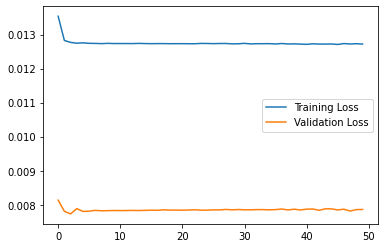

In [21]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

## Conv1D Neural Network

In [22]:
#Second model - Conv1D regressor for price prediction

regressor2 = Sequential()
regressor2.add(layers.Conv1D(filters=12, kernel_size=3, activation='relu', input_shape=(tsteps, nfeatures)))
regressor2.add(layers.Conv1D(filters=12, kernel_size=3, activation='relu'))
regressor2.add(layers.Dropout(0.5))
regressor2.add(layers.MaxPooling1D(pool_size=2))
regressor2.add(layers.Flatten())
regressor2.add(layers.Dense(10, activation='relu'))
regressor2.add(layers.Dense(forwardsteps))

regressor2.compile(optimizer='adam', loss='mse')
regressor2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 28, 12)            48        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 26, 12)            444       
_________________________________________________________________
dropout (Dropout)            (None, 26, 12)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 13, 12)            0         
_________________________________________________________________
flatten (Flatten)            (None, 156)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1570      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                

In [23]:
checkpoint = ModelCheckpoint("/kaggle/working/regressor2.hdf5", monitor='val_loss', verbose=1,save_best_only=True, mode='auto', period=1)
history2 = regressor.fit(X_train,y_train,epochs=50,batch_size=128,verbose=1,validation_data=(X_test, y_test),callbacks=[checkpoint],shuffle=False)

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 0.0127
Epoch 00001: val_loss improved from inf to 0.00789, saving model to /kaggle/working/regressor2.hdf5
12/12 [==============================] - 3s 209ms/step - loss: 0.0127 - val_loss: 0.0079
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 0.0127
Epoch 00002: val_loss improved from 0.00789 to 0.00786, saving model to /kaggle/working/regressor2.hdf5
12/12 [==============================] - 1s 97ms/step - loss: 0.0127 - val_loss: 0.0079
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 0.0127
Epoch 00003: val_loss did not improve from 0.00786
12/12 [==============================] - 1s 90ms/step - loss: 0.0127 - val_loss: 0.0079
Epoch 4/50
12/12 [==============================] - ETA: 0s - loss: 0.0127
Epoch 00004: val_loss did not improve from 0.00786
12/12 [==============================] - 1s 87ms/step - loss: 0.0127 - val_loss: 0.0079
Epoch 5/50
12/12 [=======================

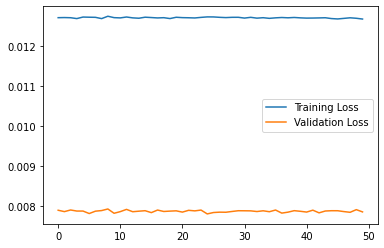

In [24]:
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend()

# Anomaly detector training

## K-Means Clustering

In [25]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(data_for_us['PRCP'].values.reshape(-1, 1))
outlier_k_means = kmeans.predict(data_for_us['PRCP'].values.reshape(-1, 1))
data_for_us['outlier'] = outlier_k_means
data_for_us.head()

,AWND,PRCP,TAVG,outlier
DATE,,,,
2015-12-26,17.28,0.3,13.1,0
2015-12-27,19.80,2.0,12.1,0
2015-12-28,22.68,1.3,7.5,0
2015-12-29,19.08,16.8,5.5,1
2015-12-30,10.80,9.4,6.2,0


In [26]:
#Saving KMeans model with pickle
import pickle
filename = '/kaggle/working/kmeans.pickle'
pickle.dump(kmeans, open(filename, 'wb'))

#To load the model
#loaded_kmeans = pickle.load(open(filename, 'rb'))

In [27]:
a = data_for_us.loc[data_for_us['outlier'] == 1] #anomaly

fig = go.Figure()
fig.add_trace(go.Scatter(x=data_for_us['PRCP'].index, y=data_for_us['PRCP'].values,mode='lines',name='NY Temperature'))
fig.add_trace(go.Scatter(x=a.index, y=a['PRCP'].values,mode='markers',name='Anomaly',marker_symbol='x',marker_size=5))
fig.update_layout(showlegend=True,title="NY Precipitation - KMeans",xaxis_title="Time",yaxis_title="Avg Precipitation",font=dict(family="Courier New, monospace"))
fig.show()

In [28]:
regressor = load_model("regressor.hdf5")
regressor.evaluate(X_test, y_test)

11/11 [==============================] - 0s 7ms/step - loss: 0.0077


0.00772923044860363

In [29]:
y_test_pred = regressor.predict(X_test[0].reshape(1,30,1))

In [30]:
y_test_pred

array([[0.0426978 , 0.04680603]], dtype=float32)

# Gathering weather data from API

In [31]:
past = datetime.now(tz=timezone.utc) - timedelta(days=30)
past = datetime.strftime(past, '%Y-%m-%d')
current = datetime.now(tz=timezone.utc).strftime('%Y-%m-%d') 

print(past)
print(current)

2020-12-15
2021-01-14


In [32]:
#Monthly data

params = {'q':'40.639,-73.764','key': '75620b01e4b1495e9ff224837202912','date':past,'enddate':current,'format':'json','tp':'24'}
month_result = requests.get('http://api.worldweatheronline.com/premium/v1/past-weather.ashx', params)
month_result = month_result.json()
month_dates = month_result["data"]["weather"]
dates = []
for i in range(len(month_dates)):
    dates.append(month_dates[i]['date'])
dates = pd.to_datetime(dates)
precipMM = []
for i in range(len(dates)):
    precipMM.append(float(month_result['data']['weather'][i]['hourly'][0]['precipMM']))
month_condition = pd.DataFrame(data=precipMM,index=dates,columns=['precipMM'])
month_condition = month_condition[-30:]
precip = month_condition.copy()
precip_scaled = scale_samples(precip,precip.columns[0],scaler)
predictions = regressor.predict(precip_scaled.values.reshape(1,30,1))
month_condition = month_condition.iloc[2:]
month_condition = month_condition.append(pd.DataFrame(scaler.inverse_transform(predictions)[0][0], index= [month_condition.index[len(month_condition)-1] + timedelta(days=1)],columns =['precipMM']))
month_condition = month_condition.append(pd.DataFrame(scaler.inverse_transform(predictions)[0][1], index= [month_condition.index[len(month_condition)-1] + timedelta(days=1)],columns =['precipMM']))

In [33]:
month_condition[-15:]

,precipMM
2021-01-02,11.900000
2021-01-03,4.300000
2021-01-04,1.200000
2021-01-05,0.000000
2021-01-06,0.000000
2021-01-07,0.000000
2021-01-08,0.000000
2021-01-09,0.000000
2021-01-10,0.000000
2021-01-11,0.000000


In [34]:
outlier = kmeans.predict(month_condition['precipMM'].values.reshape(-1, 1))
month_condition['outlier'] = outlier
month_condition.head()

,precipMM,outlier
2020-12-18,0.4,0
2020-12-19,0.0,0
2020-12-20,1.9,0
2020-12-21,0.0,0
2020-12-22,2.3,0


# Plotting forecasting and recent anomalies

In [35]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=month_condition.index, y=month_condition['precipMM'],name='NY Precipitation (mm)'))
fig.add_trace(go.Scatter(x=month_condition.loc[month_condition['outlier'] == 1].index, y=month_condition.loc[month_condition['outlier'] == 1]['precipMM'].values,mode='markers',name='Anomaly',marker_symbol='x',marker_size=10))
fig.add_vrect(x0=month_condition.index[-3], x1=month_condition.index[-1],fillcolor="LightSalmon", opacity=1,layer="below", line_width=0)
fig.update_layout(showlegend=True,title="NY Precipitation (mm)",xaxis_title="Time",yaxis_title="Temp",font=dict(family="Courier New, monospace"))
fig.show()